In [1]:
### Logistic Regression Advanced Template

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [3]:
data_for_model=pickle.load(open(r"C:\Users\12176\Desktop\lab\Data science\5. Machine_learning\2. Datasets/abc_classification_modelling.p", "rb"))

In [4]:
data_for_model.head(3)

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727


In [5]:
data_for_model.drop(["customer_id"], axis=1, inplace =True)

In [6]:
data_for_model = shuffle(data_for_model, random_state = 42)

In [7]:
data_for_model.head()

,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
714,0,1.64,M,0.58,27.81,6,3,3,9.270000
605,0,0.88,M,0.63,26.62,9,3,2,8.873333
120,0,0.56,M,0.62,886.78,154,18,4,49.265556
208,0,0.11,M,0.58,1256.19,168,34,5,36.946765
380,0,1.32,M,0.36,739.67,110,21,3,35.222381


In [8]:
## checking for missing values
data_for_model.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [9]:
## decided to drop the missing values -- small number (no need to impute)
data_for_model.dropna(how = "any", inplace =True)

In [10]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     0
gender                  0
credit_score            0
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [11]:
### class balance
data_for_model["signup_flag"].value_counts(normalize =True)

0    0.695396
1    0.304604
Name: signup_flag, dtype: float64

In [12]:
### Outliers_investigation
outlier_investigatoin=data_for_model.describe()
outlier_investigatoin

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [13]:
outlier_column=["distance_from_store","total_sales",
                "credit_score", "average_basket_value" ]
for column in outlier_column:
    
    lower_qrt=data_for_model[column].quantile(0.25)
    upper_qrt=data_for_model[column].quantile(0.75)  
    inetrqrt_range = upper_qrt - lower_qrt
    Lower_boundary = lower_qrt - (inetrqrt_range* 2)
    Upper_boundary = upper_qrt + (inetrqrt_range* 2)
    outliers = data_for_model[(data_for_model[column] < Lower_boundary) | (data_for_model[column] > Upper_boundary)].index
    
    print(f"there were {len(outliers)} outliers detecetd")
    
    data_for_model.drop(outliers, inplace=True)

there were 8 outliers detecetd
there were 54 outliers detecetd
there were 0 outliers detecetd
there were 17 outliers detecetd


In [14]:
## split input and output variables
X = data_for_model.drop(["signup_flag"], axis=1)
y = data_for_model["signup_flag"]

In [15]:
## Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify =y)

In [16]:
### Intansiate the model
clf = LogisticRegression(random_state=42)

In [17]:
### dealing with categroical variables
encoder= OneHotEncoder(sparse=False,drop= "first")
cat_vars=["gender"]
X_train_encoder=encoder.fit_transform(X_train[cat_vars])
X_test_encoder=encoder.transform(X_test[cat_vars])
feature_names= encoder.get_feature_names(cat_vars)

X_train_encoder =pd.DataFrame(X_train_encoder, columns = feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoder.reset_index(drop=True)],axis=1)
X_train.drop(cat_vars, axis =1, inplace=True)

X_test_encoder =pd.DataFrame(X_test_encoder, columns = feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoder.reset_index(drop=True)],axis=1)
X_test.drop(cat_vars, axis =1, inplace=True)

In [18]:
X_test

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,1.59,0.50,587.82,108,17,5,34.577647,1.0
1,0.88,0.56,50.08,6,2,2,25.040000,1.0
2,0.94,0.67,1141.86,204,41,5,27.850244,1.0
3,0.28,0.39,405.53,114,26,4,15.597308,1.0
4,0.16,0.45,405.80,100,26,4,15.607692,1.0
...,...,...,...,...,...,...,...,...
149,0.02,0.61,1203.23,223,39,5,30.852051,1.0
150,1.16,0.72,514.71,109,23,5,22.378696,0.0
151,2.62,0.54,37.38,6,2,1,18.690000,0.0
152,1.80,0.53,1131.45,132,32,5,35.357813,1.0


In [19]:
### Feature Selection
clf = LogisticRegression(random_state =42, max_iter =1000)
feature_selector= RFECV(clf)
fit = feature_selector.fit(X_train, y_train)
optimal_feature_count =feature_selector.n_features_
print(f"Optimal no. of features: {optimal_feature_count}")

Optimal no. of features: 7


In [20]:
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

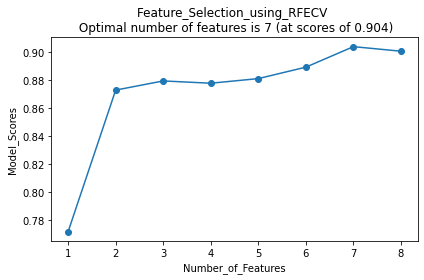

In [21]:
plt.plot(range(1, len(fit.grid_scores_)+1), fit.grid_scores_, marker="o")
plt.ylabel("Model_Scores")
plt.xlabel("Number_of_Features")
plt.title(f"Feature_Selection_using_RFECV \n Optimal number of features is {optimal_feature_count} (at scores of {round(max(fit.grid_scores_),4)})")
plt.tight_layout()
plt.show()

In [22]:
##Model Training
clf = LogisticRegression(random_state =42, max_iter =1000)
clf.fit(X_train, y_train)
y_pred_class = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_class)
accuracy

0.922077922077922

In [36]:
y_pred_class

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
      dtype=int64)

In [ ]:
X_test[9]

In [23]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred_prob

array([4.92281396e-02, 8.53557700e-05, 1.41807414e-01, 1.86656742e-03,
       1.82861923e-03, 5.76345539e-02, 1.92371074e-03, 5.65596783e-03,
       7.70140611e-01, 1.16740148e-01, 2.57355131e-02, 2.64803822e-02,
       4.37580438e-01, 9.36339656e-01, 2.35943271e-01, 9.16239746e-01,
       1.60383501e-03, 4.32165977e-03, 1.72186171e-02, 3.73294243e-02,
       1.71565097e-04, 1.40454297e-02, 3.76575127e-02, 2.53604718e-03,
       1.76965523e-02, 3.79162131e-01, 3.65141485e-04, 1.10280674e-01,
       3.02515412e-03, 1.76029771e-01, 8.64046073e-01, 5.43657500e-02,
       3.82964071e-05, 8.06108742e-01, 1.29080571e-01, 5.51560739e-01,
       8.80234387e-01, 1.64429479e-01, 7.31633129e-01, 5.32501230e-02,
       1.74589977e-01, 9.82476496e-03, 1.16537233e-02, 8.27631041e-01,
       7.88316994e-01, 6.37956783e-01, 2.27861738e-01, 6.66166269e-02,
       3.41821017e-03, 3.60355890e-03, 9.55790946e-02, 7.94523760e-01,
       7.91568543e-02, 2.77870208e-02, 5.92014671e-01, 6.05867819e-01,
      

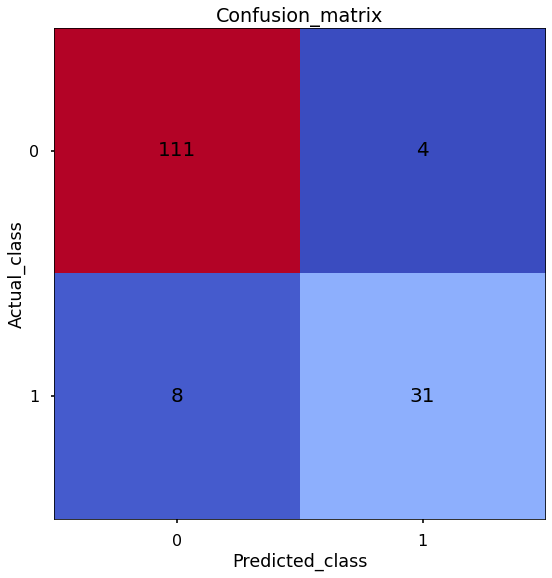

In [24]:
## confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
conf_matrix

plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap= "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion_matrix")
plt.ylabel("Actual_class")
plt.xlabel("Predicted_class")
for (i,j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j,i,corr_value, ha ="center", va ="center", fontsize =20)
plt.show()  

In [25]:
### Accuracy (the number of correct classification out of all attempted classification)
accuracy_score(y_test, y_pred_class)

0.922077922077922

In [26]:
## Precision (of all observations that were predicted negative, how many were actually positive)
precision_score(y_test, y_pred_class)

0.8857142857142857

In [27]:
## Recall (of all positive obs., how many did we predict positive )
recall_score(y_test, y_pred_class)

0.7948717948717948

In [28]:
## F1_score(the harmonic mean of precision and recall)
f1_score(y_test, y_pred_class)

0.8378378378378378

In [29]:
### Finding the optimal threshold
thresholds =np.arange(0,1,0.01)
precision_scores = []
recall_scores= []
f1_scores = []



In [30]:
for threshold in thresholds:
    
    pred_class = (y_pred_prob >= threshold) * 1
    
    precision = precision_score(y_test, pred_class, zero_division = 0)
    precision_scores.append(precision)
    
    recall = recall_score(y_test, pred_class)
    recall_scores.append(recall)  
                          
    f1 = f1_score(y_test, pred_class)
    f1_scores.append(f1)
    


In [31]:
max_f1 = max(f1_scores)
max_f1_idx = f1_scores.index(max_f1)

In [32]:
max_f1

0.8378378378378378

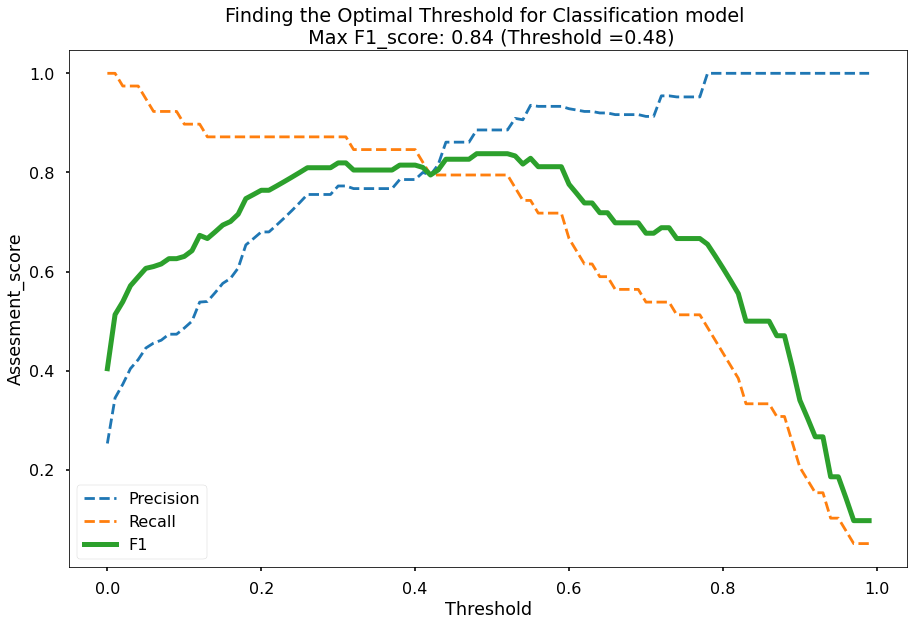

In [33]:
plt.style.use("seaborn-poster")
plt.plot(thresholds, precision_scores, label = "Precision", linestyle = "--")
plt.plot(thresholds, recall_scores, label = "Recall", linestyle = "--")
plt.plot(thresholds, f1_scores, label = "F1", linewidth = 5)
plt.title(f"Finding the Optimal Threshold for Classification model \n Max F1_score: {round(max_f1,2)} (Threshold ={round(thresholds[max_f1_idx],2)})")
plt.xlabel("Threshold")
plt.ylabel("Assesment_score")
plt.legend(loc ="lower left")
plt.tight_layout()
plt.show()

In [34]:
optimal_threshold = 0.48
y_pred_class_opt_thresh = pd.DataFrame((y_pred_prob >= optimal_threshold) * 1, columns = ["predicted_output"])
y_pred_class_opt_thresh

,predicted_output
0,0
1,0
2,0
3,0
4,0
...,...
149,0
150,0
151,0
152,0


### Pickling the model

In [35]:
import pickle
pickle.dump(clf, open('logistics.pkl', 'wb'))